In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#preliminary test to ensure GPU is working

import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
#preliminary test to check CPU Vs GPU time

import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.5999155799945584
GPU (s):
0.039510276008513756
GPU speedup over CPU: 91x


In [3]:
import numpy as np
import tensorflow as tf
import datetime
from tensorflow.keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Conv2DTranspose, UpSampling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import TensorBoard
#import tensorflow_addons as tfa
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook

import random
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [4]:
artists = pd.read_csv(r'art5.csv')
artists.shape

(5, 8)

In [5]:
#specify the directory containing the image-training set

images_dir = r'train'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists['name'].str.replace(' ', '_').values

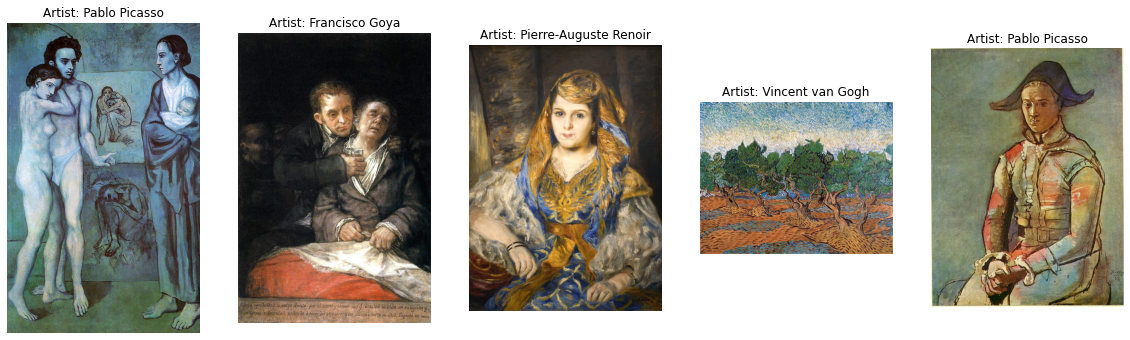

In [6]:
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

In [7]:
batch_size = 1
train_input_shape = (256, 256,3)
n_classes = artists.shape[0]

In [8]:
img_width, img_height = 256, 256

In [9]:
#this section implements the data generation and data augmentation

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   rotation_range=45,
                                   width_shift_range=0.5,
                                   height_shift_range=0.5,
                                   shear_range=5,
                                   zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=(img_width, img_height),
                                                    color_mode="rgb",
                                                    batch_size=120,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=(img_width, img_height),
                                                    color_mode="rgb",
                                                    batch_size=30,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)



Found 1314 images belonging to 5 classes.
Found 326 images belonging to 5 classes.
Total number of batches = 10 and 10


In [10]:
X_train, y_train = train_generator.next()
X_test, y_test = valid_generator.next()

In [11]:
y_train.shape

(120, 5)

In [15]:
pip install tensorflow_addons

Note: you may need to restart the kernel to use updated packages.


In [12]:
from tensorflow import keras
from tensorflow.keras import layers

In [13]:
n_epoch = 200
# early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
#                            mode='auto', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, 
                              verbose=1, mode='auto')


## VGG16 model:

In [18]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
vgg = VGG16(input_shape=[256,256]+[3],weights='imagenet',include_top=False)
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(5,activation='softmax')(x)
model1 = Model(inputs=vgg.input,outputs=prediction)

In [19]:
model1.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [20]:
history4 = model1.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=50,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr]
                             )

Epoch 1/50
10/10 [==============================] - 88s 7s/step - loss: 2.5948 - accuracy: 0.2379 - val_loss: 1.5540 - val_accuracy: 0.4200
Epoch 2/50
10/10 [==============================] - 47s 5s/step - loss: 1.4712 - accuracy: 0.4388 - val_loss: 1.2068 - val_accuracy: 0.5533
Epoch 3/50
10/10 [==============================] - 48s 5s/step - loss: 1.1201 - accuracy: 0.5733 - val_loss: 1.1238 - val_accuracy: 0.5833
Epoch 4/50
10/10 [==============================] - 48s 5s/step - loss: 1.0751 - accuracy: 0.5984 - val_loss: 1.0580 - val_accuracy: 0.6233
Epoch 5/50
10/10 [==============================] - 48s 5s/step - loss: 0.9574 - accuracy: 0.6467 - val_loss: 0.9892 - val_accuracy: 0.5867
Epoch 6/50
10/10 [==============================] - 47s 5s/step - loss: 0.9382 - accuracy: 0.6222 - val_loss: 1.0346 - val_accuracy: 0.6100
Epoch 7/50
10/10 [==============================] - 48s 5s/step - loss: 0.9297 - accuracy: 0.6305 - val_loss: 0.9956 - val_accuracy: 0.6133
Epoch 8/50
10/10 [==

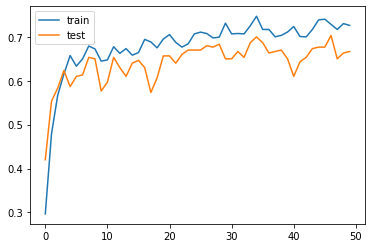

In [21]:
from matplotlib import pyplot
pyplot.plot(history4.history['accuracy'], label='train')
pyplot.plot(history4.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## Xception model:

In [22]:
base_model=tf.keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
prediction = Dense(5,activation='softmax')(x)
model2 = Model(inputs=base_model.input,outputs=prediction)
#model2.summary()

83689472/83683744 [==============================] - 1s 0us/step


In [23]:
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [25]:
history5 = model2.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=50,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr]
                             )

Epoch 1/50
10/10 [==============================] - 54s 5s/step - loss: 10.3805 - accuracy: 0.2460 - val_loss: 6.7304 - val_accuracy: 0.5167
Epoch 2/50
10/10 [==============================] - 47s 5s/step - loss: 6.1500 - accuracy: 0.4668 - val_loss: 4.4963 - val_accuracy: 0.5467
Epoch 3/50
10/10 [==============================] - 47s 5s/step - loss: 3.6915 - accuracy: 0.6054 - val_loss: 3.1007 - val_accuracy: 0.6000
Epoch 4/50
10/10 [==============================] - 46s 5s/step - loss: 2.6382 - accuracy: 0.6451 - val_loss: 2.4200 - val_accuracy: 0.6167
Epoch 5/50
10/10 [==============================] - 46s 5s/step - loss: 1.9002 - accuracy: 0.6607 - val_loss: 2.0260 - val_accuracy: 0.6667
Epoch 6/50
10/10 [==============================] - 46s 5s/step - loss: 1.7566 - accuracy: 0.6733 - val_loss: 2.3551 - val_accuracy: 0.6133
Epoch 7/50
10/10 [==============================] - 46s 5s/step - loss: 1.6275 - accuracy: 0.6740 - val_loss: 1.9913 - val_accuracy: 0.6133
Epoch 8/50
10/10 [=

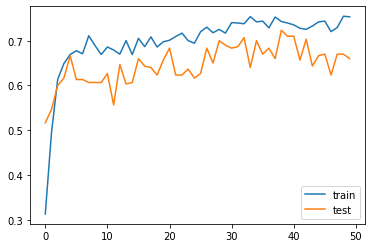

In [26]:
pyplot.plot(history5.history['accuracy'], label='train')
pyplot.plot(history5.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## MobileNet model:

In [14]:
base_model=tf.keras.applications.MobileNet(
    input_shape=(256,256,3),
    alpha=1.0,
    depth_multiplier=1,
    dropout=0.001,
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
prediction = Dense(5,activation='softmax')(x)
model3 = Model(inputs=base_model.input,outputs=prediction)
#model3.summary()

In [15]:
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
history6 = model3.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=50,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr]
                             )

Epoch 1/50
10/10 [==============================] - 49s 5s/step - loss: 18.0379 - accuracy: 0.2242 - val_loss: 19.1613 - val_accuracy: 0.4000
Epoch 2/50
10/10 [==============================] - 45s 5s/step - loss: 11.6406 - accuracy: 0.4850 - val_loss: 4.2659 - val_accuracy: 0.6467
Epoch 3/50
10/10 [==============================] - 45s 5s/step - loss: 4.5551 - accuracy: 0.6227 - val_loss: 3.6407 - val_accuracy: 0.6267
Epoch 4/50
10/10 [==============================] - 45s 5s/step - loss: 3.3327 - accuracy: 0.6869 - val_loss: 3.0205 - val_accuracy: 0.6900
Epoch 5/50
10/10 [==============================] - 44s 5s/step - loss: 2.8601 - accuracy: 0.6711 - val_loss: 2.5424 - val_accuracy: 0.6967
Epoch 6/50
10/10 [==============================] - 45s 5s/step - loss: 1.9460 - accuracy: 0.7405 - val_loss: 2.9127 - val_accuracy: 0.6567
Epoch 7/50
10/10 [==============================] - 46s 5s/step - loss: 2.0858 - accuracy: 0.7025 - val_loss: 2.1954 - val_accuracy: 0.6933
Epoch 8/50
10/10 

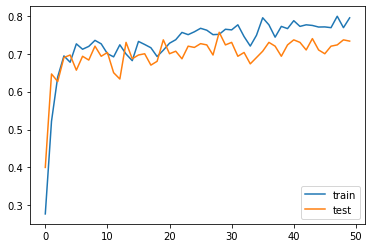

In [18]:
from matplotlib import pyplot
pyplot.plot(history6.history['accuracy'], label='train')
pyplot.plot(history6.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

## 4. ResNet50 Model:

In [19]:
base_model=tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(256,256,3),
    pooling=None,
    classes=1000
)

for layer in base_model.layers:
    layer.trainable = False

x = Flatten()(base_model.output)
prediction = Dense(5,activation='softmax')(x)
model4 = Model(inputs=base_model.input,outputs=prediction)

In [20]:
model4.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [22]:
history7 = model4.fit(train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=50,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr]
                             )

Epoch 1/50
10/10 [==============================] - 50s 5s/step - loss: 19.4375 - accuracy: 0.2295 - val_loss: 12.5876 - val_accuracy: 0.2533
Epoch 2/50
10/10 [==============================] - 48s 5s/step - loss: 9.7708 - accuracy: 0.2521 - val_loss: 10.0044 - val_accuracy: 0.2433
Epoch 3/50
10/10 [==============================] - 47s 5s/step - loss: 5.7103 - accuracy: 0.2722 - val_loss: 2.9477 - val_accuracy: 0.3533
Epoch 4/50
10/10 [==============================] - 47s 5s/step - loss: 2.9216 - accuracy: 0.3174 - val_loss: 2.3680 - val_accuracy: 0.3267
Epoch 5/50
10/10 [==============================] - 46s 5s/step - loss: 2.0488 - accuracy: 0.3191 - val_loss: 1.8283 - val_accuracy: 0.3667
Epoch 6/50
10/10 [==============================] - 46s 5s/step - loss: 1.8380 - accuracy: 0.3601 - val_loss: 1.7529 - val_accuracy: 0.4467
Epoch 7/50
10/10 [==============================] - 46s 5s/step - loss: 1.5947 - accuracy: 0.4070 - val_loss: 1.4968 - val_accuracy: 0.3867
Epoch 8/50
10/10 

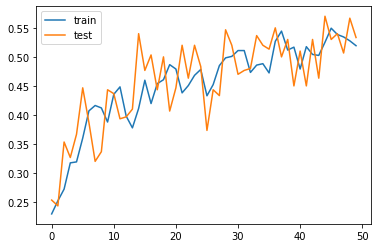

In [23]:
pyplot.plot(history7.history['accuracy'], label='train')
pyplot.plot(history7.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()